#### add SNPs as input feature for machine learning (cutoff p=5e-5/p=1e-6)

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold

In [2]:
# fetch SNPs
db_SNP = pd.read_csv('../datasets/6p/ukb_poi40_6p.regenie',sep='\t')
snp_list = db_SNP['ID'].tolist()
snp_list

['rs556528578',
 'rs185601219',
 'rs560692838',
 'rs563775604',
 'rs542929480',
 '3:34292328_TTA_T',
 'rs62249105',
 'rs185772271',
 'rs537830746',
 'rs768266341',
 'rs566445876',
 'rs191952533',
 'rs755756481',
 'rs189016755',
 'rs550900164',
 'rs542067260',
 'rs7734062',
 'rs147199219',
 'rs546845067',
 'rs543206187',
 'rs138891260',
 'rs182914745',
 'rs539238274',
 'rs777348387',
 'rs192400591',
 'rs35428653',
 'rs564244863',
 'rs556904966',
 'rs553351149',
 'rs540433729',
 'rs564458221',
 'rs117231204',
 'rs73440140',
 'rs750936607',
 'rs777830741',
 'rs765216572',
 'rs536590880',
 'rs768326402',
 'rs148396040',
 '18:39762443_AG_A',
 'rs349310',
 'rs7507835',
 'rs778029269',
 'rs181728572',
 'rs35088421',
 'rs10403600',
 'rs4806658',
 'rs1172816',
 '19:55809016_AC_A',
 'rs1551562',
 'rs1172820',
 'rs1172821',
 'rs1172822',
 'rs35931424',
 'rs7246479',
 'rs4806659',
 'rs4806660',
 'rs4806661',
 '19:55824817_CTG_C',
 'rs35515212',
 'rs8107664',
 'rs11433324',
 'rs34962991',
 'rs11399

In [3]:
base_df_case = pd.read_csv('../datasets/final/cleaned_case.csv')
base_df_control = pd.read_csv('../datasets/final/cleaned_control.csv')
base_df_case.head()

,eid,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,alcohol intake frequency,salad/raw vegetable intake,fresh fruit intake,cooked vegetable intake,pork intake,qualifications,BMI,HDL-C,LDL-C,apolipoprotein B,treatment/medication code,ICD10,T2D
0,1004331,0,9,1,1,0,0,0,2,0,0,0,18.2098,-1.165660,-0.314136,0.925,0,0,0.000000
1,1005087,0,7,0,4,0,0,2,4,2,0,0,31.2883,1.115530,-0.377054,1.082,0,0,0.000000
2,1007659,0,5,1,0,0,0,3,2,3,1,1,31.8405,-0.464109,1.570590,1.113,0,0,-0.395678
3,1014838,0,7,0,1,4,0,1,0,1,0,0,24.3080,0.150831,1.169080,1.209,0,0,0.000000
4,1019851,0,9,0,5,0,0,1,2,3,0,0,25.1797,-0.638671,1.749310,0.835,1,0,0.442098


In [4]:
# merge SNPs
left_rsid = []
for rsid in snp_list:
    rsid = rsid.replace(':','_')
    try:
        genotype = pd.read_csv('../datasets/final_6p/ped_snp_case_' + rsid + '.csv')
        A1 = genotype['A1'].tolist()
        A2 = genotype['A2'].tolist()
        base_df_case[rsid + 'A1'] = A1
        base_df_case[rsid + 'A2'] = A2
        left_rsid.append(rsid)
    except FileNotFoundError:
        pass
for rsid in snp_list:
    rsid = rsid.replace(':','_')
    try:
        genotype = pd.read_csv('../datasets/final_6p/ped_snp_control_' + rsid + '.csv')
        A1 = genotype['A1'].tolist()
        A2 = genotype['A2'].tolist()
        base_df_control[rsid + 'A1'] = A1
        base_df_control[rsid + 'A2'] = A2
    except FileNotFoundError:
        pass
print(base_df_case.shape)
print(base_df_control.shape)
base_df_case.to_csv('../datasets/final_6p/merged_snp_case.csv',index=False)
base_df_control.to_csv('../datasets/final_6p/merged_snp_control.csv',index=False)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_45468\3766904563.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_df_case[rsid + 'A1'] = A1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_45468\3766904563.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_df_case[rsid + 'A2'] = A2
C:\Users\Administrator\AppData\Local\Temp\ipykernel_45468\3766904563.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

(10625, 189)
(50587, 189)


In [5]:
# remove samples without genotype
base_df_case = pd.read_csv('../datasets/final_6p/merged_snp_case.csv')
base_df_control = pd.read_csv('../datasets/final_6p/merged_snp_control.csv')
for rsid in left_rsid:
    base_df_case = base_df_case.drop(base_df_case[base_df_case[rsid + 'A1'].str.contains('-')].index)
    base_df_case = base_df_case.drop(base_df_case[base_df_case[rsid + 'A1'].str.contains('0')].index)
base_df_case = base_df_case.reset_index(drop=True)
print(base_df_case.shape)
for rsid in left_rsid:
    base_df_control = base_df_control.drop(base_df_control[base_df_control[rsid + 'A1'].str.contains('-')].index)
    base_df_control = base_df_control.drop(base_df_control[base_df_control[rsid + 'A1'].str.contains('0')].index)
base_df_control = base_df_control.reset_index(drop=True)
print(base_df_control.shape)
base_df_case.to_csv('../datasets/final_6p/filtered_snp_case.csv',index=False)
base_df_control.to_csv('../datasets/final_6p/filtered_snp_control.csv',index=False)
base_df_case.iloc[:,0:19].to_csv('../datasets/final_6p/filtered_nosnp_case.csv',index=False)
base_df_control.iloc[:,0:19].to_csv('../datasets/final_6p/filtered_nosnp_control.csv',index=False)

(3261, 189)
(3279, 189)


In [6]:
# encode genotype into int datatype
base_df_case = pd.read_csv('../datasets/final_6p/filtered_snp_case.csv')
base_df_control = pd.read_csv('../datasets/final_6p/filtered_snp_control.csv')
for rsid in left_rsid:
    A = list(set(base_df_case[rsid + 'A1'].tolist()+base_df_case[rsid + 'A2'].tolist()+base_df_control[rsid + 'A1'].tolist()+base_df_control[rsid + 'A2'].tolist()))
    if(len(A) == 1):
        base_df_case[rsid + 'A1'].replace('^' + A[0],0,inplace=True,regex=True)
        base_df_case[rsid + 'A2'].replace('^' + A[0],0,inplace=True,regex=True)
        base_df_control[rsid + 'A1'].replace('^' + A[0],0,inplace=True,regex=True)
        base_df_control[rsid + 'A2'].replace('^' + A[0],0,inplace=True,regex=True)
    else:
        base_df_case[rsid + 'A1'].replace('^' + A[0],0,inplace=True,regex=True)
        base_df_case[rsid + 'A1'].replace('^' + A[1],1,inplace=True,regex=True)
        base_df_case[rsid + 'A2'].replace('^' + A[0],0,inplace=True,regex=True)
        base_df_case[rsid + 'A2'].replace('^' + A[1],1,inplace=True,regex=True)
        base_df_control[rsid + 'A1'].replace('^' + A[0],0,inplace=True,regex=True)
        base_df_control[rsid + 'A1'].replace('^' + A[1],1,inplace=True,regex=True)
        base_df_control[rsid + 'A2'].replace('^' + A[0],0,inplace=True,regex=True)
        base_df_control[rsid + 'A2'].replace('^' + A[1],1,inplace=True,regex=True)
        
base_df_case.to_csv('../datasets/final_6p/filtered_ensnp_case.csv',index=False)
base_df_control.to_csv('../datasets/final_6p/filtered_ensnp_control.csv',index=False)

#### start machine learning

In [7]:
# for NO-SNP model
df_case = pd.read_csv('../datasets/final/filtered_nosnp_case.csv',index_col=0)
df_control = pd.read_csv('../datasets/final/filtered_nosnp_control.csv',index_col=0)
df_case = df_case.reset_index(drop=True)
df_control = df_control.reset_index(drop=True)

# data preparing
case_cohort = df_case.astype('float32')
control_cohort = df_control.astype('float32')

case_cohort.insert(case_cohort.shape[1], 'label', 1)
control_cohort.insert(control_cohort.shape[1], 'label', 0)
merged = pd.concat([case_cohort, control_cohort])
merged = merged.fillna(0)
merged

,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,alcohol intake frequency,salad/raw vegetable intake,fresh fruit intake,cooked vegetable intake,pork intake,qualifications,BMI,HDL-C,LDL-C,apolipoprotein B,treatment/medication code,ICD10,T2D,label
0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,18.209801,-1.165660,-0.314136,0.925,0.0,0.0,0.000000,1
1,0.0,5.0,1.0,0.0,0.0,0.0,3.0,2.0,3.0,1.0,1.0,31.840500,-0.464109,1.570590,1.113,0.0,0.0,-0.395678,1
2,0.0,7.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,24.308001,0.150831,1.169080,1.209,0.0,0.0,0.000000,1
3,0.0,9.0,0.0,5.0,0.0,0.0,1.0,2.0,3.0,0.0,0.0,25.179701,-0.638671,1.749310,0.835,1.0,0.0,0.442098,1
4,0.0,8.0,0.0,3.0,3.0,1.0,2.0,2.0,2.0,0.0,0.0,24.238800,0.620372,-0.228362,1.136,0.0,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,0.0,6.0,1.0,3.0,1.0,0.0,2.0,1.0,3.0,0.0,0.0,25.279200,0.701604,1.341460,1.046,0.0,0.0,-1.181410,0
7488,0.0,7.0,0.0,5.0,0.0,0.0,5.0,3.0,5.0,0.0,1.0,27.143299,0.980930,0.244087,1.033,0.0,0.0,-0.425100,0
7489,0.0,8.0,0.0,2.0,3.0,1.0,3.0,4.0,3.0,0.0,0.0,21.757401,-0.156365,-1.349850,0.806,0.0,0.0,0.000000,0
7490,0.0,7.0,0.0,3.0,2.0,1.0,1.0,5.0,1.0,0.0,1.0,22.382799,-2.221720,1.323120,0.980,0.0,0.0,0.000000,0


In [8]:
# shuffle and split dataset

#dropped = merged.drop('eid',axis=1)
shuffled = shuffle(merged)
train_data = shuffled[0:int(shuffled.shape[0]*0.9)]
test_data = shuffled[int(shuffled.shape[0]*0.9):]
print(train_data.shape[0])
print(test_data.shape[0])

# fetch values
nor_feature_train = train_data.drop('label',axis=1)
X_train = nor_feature_train.values
nor_feature_test = test_data.drop('label',axis=1)
X_test = nor_feature_test.values
Y_train = train_data['label'].values
Y_test = test_data['label'].values

nor_feature = shuffled.drop('label',axis=1)
X = nor_feature.values
Y = shuffled['label'].values

13416
1491


(mean) ACC:  0.5669150090074158 Precision:  0.5670142474716819 Recall:  0.5470096310043521 F1:  0.5567829201709069 AUC:  0.6067897851307412
(std) ACC:  0.007667769450765841 Precision:  0.008499575901516282 Recall:  0.013225547858224584 F1:  0.009892936795522587 AUC:  0.00849538632537239


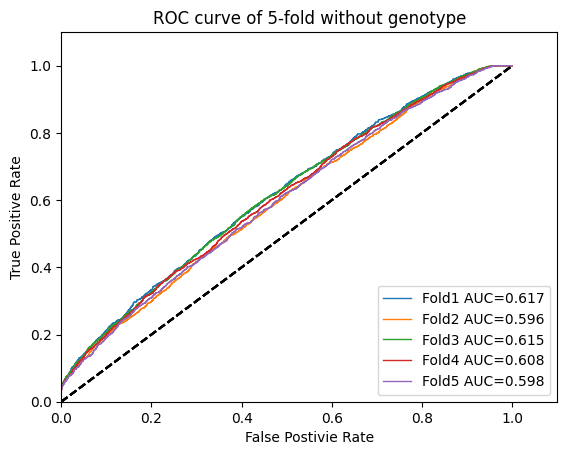

In [9]:
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold without genotype')
plt.savefig('../images/ROC-noSNP-5fold.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [10]:
# for SNP model
df_case = pd.read_csv('../datasets/final/filtered_ensnp_case.csv',index_col=0)
df_control = pd.read_csv('../datasets/final/filtered_ensnp_control.csv',index_col=0)
df_case = df_case.reset_index(drop=True)
df_control = df_control.reset_index(drop=True)

# data preparing
case_cohort = df_case.astype('float32')
control_cohort = df_control.astype('float32')

case_cohort.insert(case_cohort.shape[1], 'label', 1)
control_cohort.insert(control_cohort.shape[1], 'label', 0)
merged = pd.concat([case_cohort, control_cohort])
merged = merged.fillna(0)
merged

,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,alcohol intake frequency,salad/raw vegetable intake,fresh fruit intake,cooked vegetable intake,pork intake,...,rs10425848A2,rs11084393A1,rs11084393A2,rs2384686A1,rs2384686A2,rs371808578A1,rs371808578A2,rs4806664A1,rs4806664A2,label
0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1
1,0.0,5.0,1.0,0.0,0.0,0.0,3.0,2.0,3.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
2,0.0,7.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1
3,0.0,9.0,0.0,5.0,0.0,0.0,1.0,2.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
4,0.0,8.0,0.0,3.0,3.0,1.0,2.0,2.0,2.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,0.0,6.0,1.0,3.0,1.0,0.0,2.0,1.0,3.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
7488,0.0,7.0,0.0,5.0,0.0,0.0,5.0,3.0,5.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0
7489,0.0,8.0,0.0,2.0,3.0,1.0,3.0,4.0,3.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
7490,0.0,7.0,0.0,3.0,2.0,1.0,1.0,5.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0


In [11]:
# shuffle and split dataset

#dropped = merged.drop('eid',axis=1)
shuffled = shuffle(merged)
train_data = shuffled[0:int(shuffled.shape[0]*0.9)]
test_data = shuffled[int(shuffled.shape[0]*0.9):]
print(train_data.shape[0])
print(test_data.shape[0])

# fetch values
nor_feature_train = train_data.drop('label',axis=1)
X_train = nor_feature_train.values
nor_feature_test = test_data.drop('label',axis=1)
X_test = nor_feature_test.values
Y_train = train_data['label'].values
Y_test = test_data['label'].values

nor_feature = shuffled.drop('label',axis=1)
X = nor_feature.values
Y = shuffled['label'].values

13416
1491


(mean) ACC:  0.5664443554989784 Precision:  0.5663830277900758 Recall:  0.5481592828401392 F1:  0.5570791382021947 AUC:  0.6045287972319275
(std) ACC:  0.009621069065591726 Precision:  0.013647088307893523 Recall:  0.008935634870177974 F1:  0.010302641105628446 AUC:  0.006525430766839288


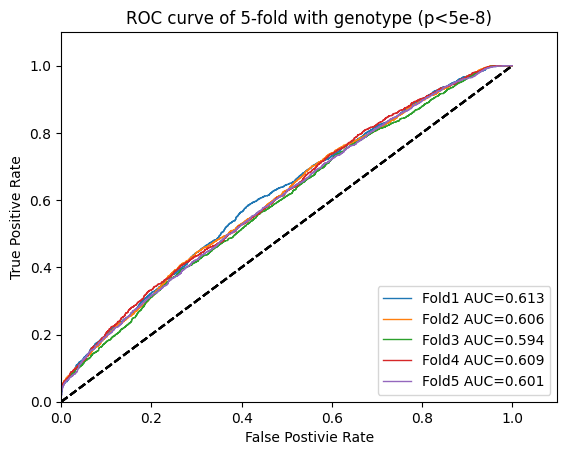

In [12]:
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold with genotype (p<5e-8)')
plt.savefig('../images/5p-ROC-SNP-5fold.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [13]:
# for SNP model (1e-6)
df_case = pd.read_csv('../datasets/final_6p/filtered_ensnp_case.csv',index_col=0)
df_control = pd.read_csv('../datasets/final_6p/filtered_ensnp_control.csv',index_col=0)
df_case = df_case.reset_index(drop=True)
df_control = df_control.reset_index(drop=True)

# data preparing
case_cohort = df_case.astype('float32')
control_cohort = df_control.astype('float32')

case_cohort.insert(case_cohort.shape[1], 'label', 1)
control_cohort.insert(control_cohort.shape[1], 'label', 0)
merged = pd.concat([case_cohort, control_cohort])
merged = merged.fillna(0)
merged

,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,alcohol intake frequency,salad/raw vegetable intake,fresh fruit intake,cooked vegetable intake,pork intake,...,rs4806664A2,rs34563859A1,rs34563859A2,rs12459907A1,rs12459907A2,rs557652995A1,rs557652995A2,rs200896099A1,rs200896099A2,label
0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1
1,0.0,7.0,0.0,1.0,4.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,6.0,0.0,2.0,4.0,0.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,7.0,1.0,3.0,7.0,0.0,1.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,8.0,0.0,5.0,0.0,0.0,2.0,2.0,2.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,0.0,7.0,0.0,2.0,6.0,0.0,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3275,0.0,7.0,0.0,1.0,1.0,0.0,2.0,3.0,4.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
3276,0.0,8.0,0.0,2.0,0.0,1.0,1.0,1.0,3.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3277,0.0,7.0,0.0,3.0,2.0,1.0,1.0,5.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
# shuffle and split dataset

#dropped = merged.drop('eid',axis=1)
shuffled = shuffle(merged)
train_data = shuffled[0:int(shuffled.shape[0]*0.9)]
test_data = shuffled[int(shuffled.shape[0]*0.9):]
print(train_data.shape[0])
print(test_data.shape[0])

# fetch values
nor_feature_train = train_data.drop('label',axis=1)
X_train = nor_feature_train.values
nor_feature_test = test_data.drop('label',axis=1)
X_test = nor_feature_test.values
Y_train = train_data['label'].values
Y_test = test_data['label'].values

nor_feature = shuffled.drop('label',axis=1)
X = nor_feature.values
Y = shuffled['label'].values

5886
654


(mean) ACC:  0.5565749235474007 Precision:  0.5554223341079793 Recall:  0.5563967869220839 F1:  0.5557103029080868 AUC:  0.5930965874552273
(std) ACC:  0.009237802732105947 Precision:  0.015021067872566603 Recall:  0.013978536889844942 F1:  0.009874789075853554 AUC:  0.010499579738603987


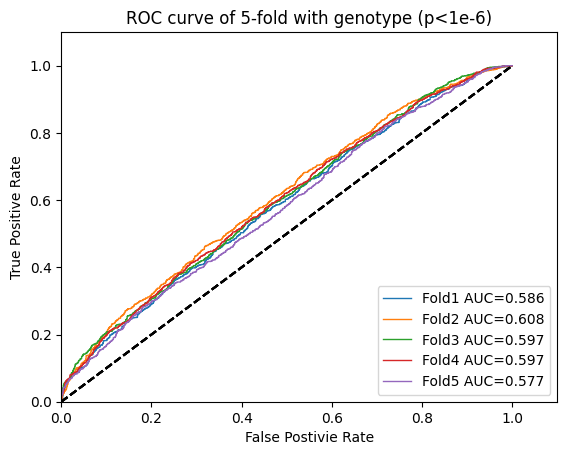

In [15]:
cv_result = []
cv_label = []
cv = KFold(n_splits=5)
for train_index, valid_index in cv.split(X):
    train_x,test_x = X[train_index], X[valid_index]
    train_y,test_y = Y[train_index], Y[valid_index]
    #clf = xgb.XGBClassifier(n_jobs=-1,n_estimators=15,max_depth=6)
    clf = xgb.XGBClassifier(n_jobs=-1)
    clf.fit(train_x, train_y)
    result = clf.predict_proba(test_x)
    cv_result.append(result)
    cv_label.append(test_y)
#print(cv_result)
#print(cv_label)

acc_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []

for i in range(5): # 5-fold evaluation
    y_score = cv_result[i].argmax(axis=1)                                   
    y_score_pro = cv_result[i] # (.., 2)
    y_one_hot = to_categorical(cv_label[i])
    y_score_one_hot = to_categorical(y_score)

    acc_list.append(accuracy_score(cv_label[i], y_score))
    precision_list.append(precision_score(cv_label[i], y_score))
    recall_list.append(recall_score(cv_label[i], y_score))
    f1_list.append(f1_score(cv_label[i], y_score))

    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
    auc_list.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, linewidth = 1,label='Fold' + str(i+1) + ' AUC=%.3f' % auc(fpr, tpr))
    plt.plot([0,1],[0,1], 'k--')

print('(mean) ACC: ', np.mean(acc_list), 'Precision: ', np.mean(precision_list), 'Recall: ', np.mean(recall_list), 'F1: ', np.mean(f1_list), 'AUC: ', np.mean(auc_list))
print('(std) ACC: ', np.std(acc_list), 'Precision: ', np.std(precision_list), 'Recall: ', np.std(recall_list), 'F1: ', np.std(f1_list), 'AUC: ', np.std(auc_list))
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve of 5-fold with genotype (p<1e-6)')
plt.savefig('../images/6p-ROC-SNP-5fold.png',dpi=300, bbox_inches = 'tight')
plt.show()

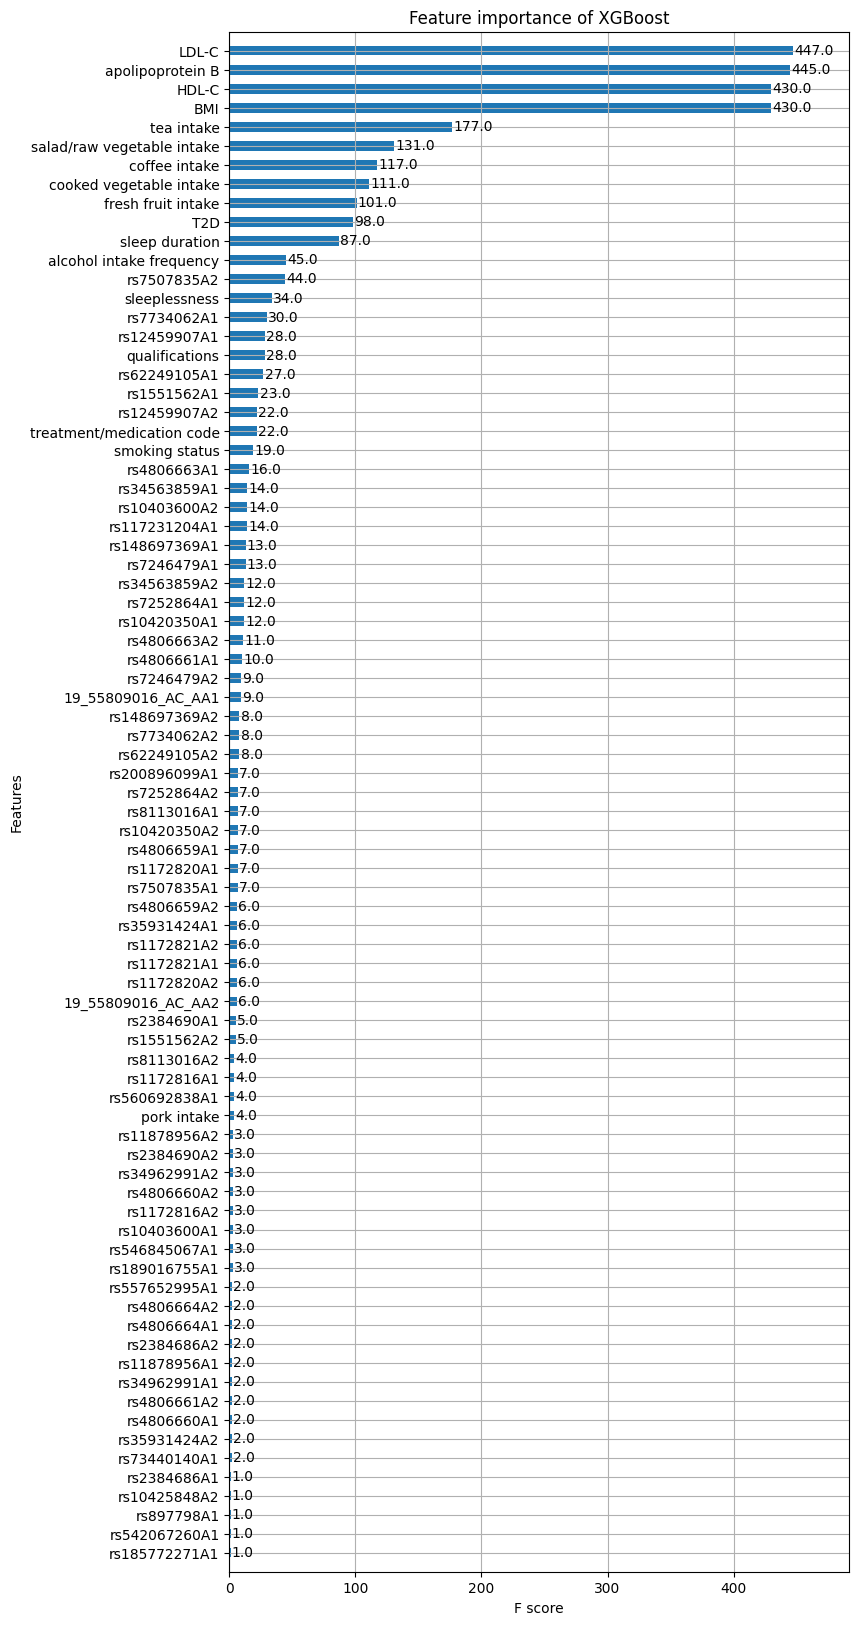

In [16]:
## feature importance
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import xgboost

clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X,Y)

# xgboost
fig,ax = plt.subplots(figsize=(8,20))
model_name='XGBoost'
feature_names = merged.drop(columns=['label']).columns.values.tolist()
clf_xgb.get_booster().feature_names = feature_names
xgboost.plot_importance(clf_xgb, ax=ax,height=0.5)
plt.title('Feature importance of '  + model_name)
plt.savefig('../images/6p-snp_feature_' + model_name,dpi=300, bbox_inches = 'tight')
plt.show()